# Exercise 1-7

Load the data set for fluid flow past a cylinder (you can either download this from our book
[http://DMDbook.com](http://DMDbook.com) or generate it using the IBPM code on GitHub).
Each column is a flow field that has been reshaped into a vector.

---

**(a)** Compute the SVD of this data set and plot the singular value spectrum and the leading singular vectors.  
The **U** matrix contains eigenflows and the **ΣV\*** represents the amplitudes of these eigenflows as the flow evolves in time.

---

**(b)** Write a code to plot the reconstructed movie for various truncation values *r*.  
Compute the *r* value needed to capture 90%, 99%, and 99.9% of the flow energy based on the singular value spectrum  
(recall that energy is given by the Frobenius norm squared).  
Plot the movies for each of these truncation values and compare the fidelity.  
Also compute the squared Frobenius norm of the error between the true matrix **X** and the reconstructed matrix **X̂**, where **X** is the flow field movie.

---

**(c)** Fix a value *r = 10* and compute the truncated SVD.  
Each column **wₖ ∈ ℝ¹⁰** of the matrix **W = Σ̂V̂\*** represents the mixture of the first 10 eigenflows in the *k*th column of **X**.  
Verify this by comparing the *k*th snapshot of **X** with **Ûwₖ**.

---

**(d)** Now, build a linear regression model for how the amplitudes **wₖ** evolve in time.  
This will be a dynamical system:

**wₖ₊₁ = A wₖ**

Create a matrix **W** with the first 1 through *m – 1* columns of **ΣV\*** and another matrix **W′** with the 2 through *m* columns of **ΣV\***.  
We will now try to solve for a best-fit **A** matrix so that

**W′ ≈ A W**

Compute the SVD of **W** and use this to compute the pseudo-inverse of **W** to solve for **A**.  
Compute the eigenvalues of **A** and plot them in the complex plane.

---

**(e)** Use this **A** matrix to advance the state **wₖ = A^(k–1)w₁** starting from **w₁**.  
Plot the reconstructed flow field using these predicted amplitude vectors and compare with the true values.


C:\Users\andre\AppData\Local\Temp\ipykernel_16360\2998764657.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nx, ny = int(data['nx']), int(data['ny'])


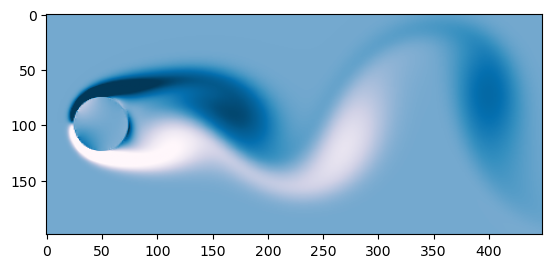

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.io import loadmat
import pandas as pd
import os
data = loadmat(os.path.join("..","data","CYLINDER_ALL.mat"))
X = data['VORTALL']
nx, ny = int(data['nx']), int(data['ny'])
vmin, vmax = np.percentile(X, 1), np.percentile(X, 99) # Para tener una escala de color consistente, 
                                                       #primera vez que lo uso, antes nose que tan corectas quedaron las graficas
    
plt.imshow(X[:,1].reshape((nx,ny),order='F'),cmap='PuBu', vmin=vmin, vmax=vmax)

Text(0, 0.5, 'Cumulative sum $\\sigma_r$')

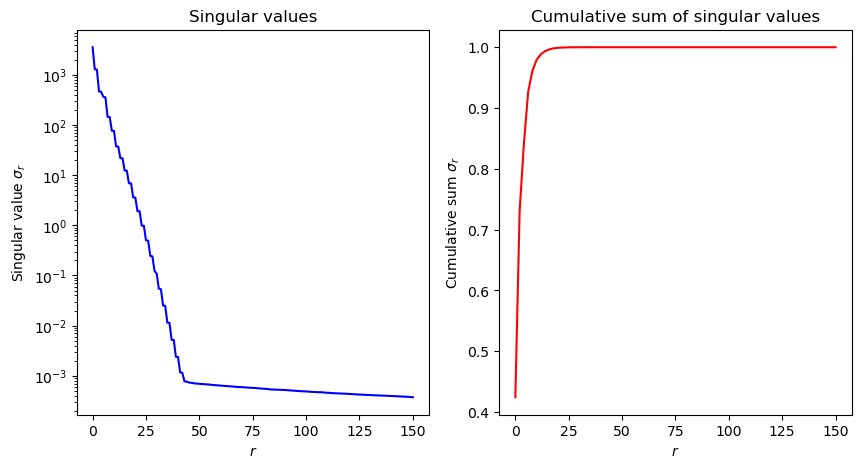

In [2]:
# Grafocar los valores singulares y su suma acumulada 
U, S, Vt = np.linalg.svd(X,full_matrices=False)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].semilogy(S,"b")
ax[0].set_title("Singular values")
ax[0].set_xlabel(r'$r$')
ax[0].set_ylabel(r'Singular value $\sigma_r$')
ax[1].plot(np.cumsum(S)/np.sum(S),"r")
ax[1].set_title("Cumulative sum of singular values")
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'Cumulative sum $\sigma_r$')

In [3]:
# b Reconstruir el flujo con distintos valores de r

total_energy = np.sum(S**2)
cumulative_energy = np.cumsum(S**2)
rel_energy = cumulative_energy / total_energy
r90 = np.searchsorted(rel_energy, 0.9) + 1
r99 = np.searchsorted(rel_energy, 0.99) + 1
r999 = np.searchsorted(rel_energy, 0.999) + 1
r_values = [2, r90, r99, r999] # Agrego 2 para ver una reconstruccion muy pobre

print(f"r para: 90% {r90}")
print(f"r para: 99% {r99}")
print(f"r para: 99.9% {r999}")

r para: 90% 3
r para: 99% 7
r para: 99.9% 9


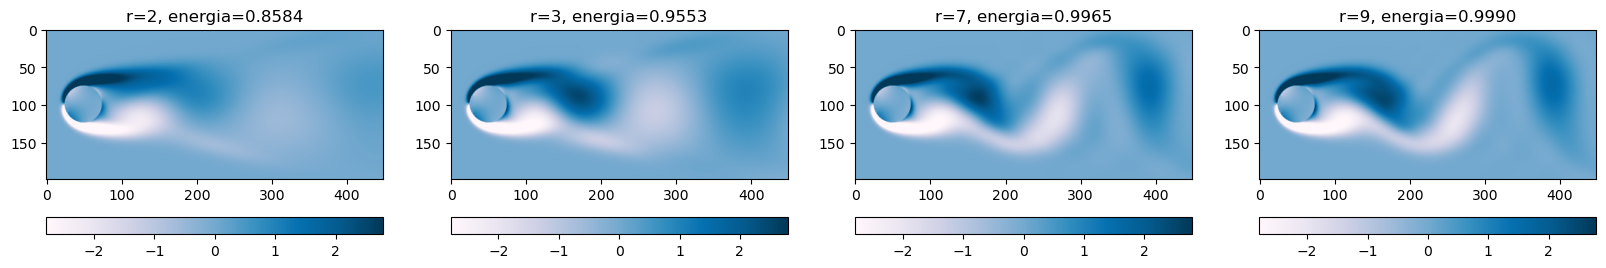

In [4]:
# Reconstruccion estatica
fig, axes = plt.subplots(1,len(r_values), figsize=(20,5))
for ax, r in zip(axes, r_values):
    Xr = U[:,:r] @ np.diag(S[:r]) @ Vt[:r,:]
    snapshot = Xr[:,0].reshape((nx,ny),order='F')
    im = ax.imshow(snapshot,cmap='PuBu', vmin=vmin, vmax=vmax)
    ax.set_title(f"r={r}, energia={rel_energy[r-1]:.4f}")
    fig.colorbar(im, ax=ax,orientation='horizontal',pad=0.1)

In [30]:
# Reconstruccion animada
Xrs = [U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :] for r in r_values]
n_frames = min(Xr.shape[1] for Xr in Xrs) # Para comparar de forma justa las animaciones
fig, axes = plt.subplots(2, 2, figsize=(12, 5),constrained_layout=True)
ims = []
axes_flat = axes.ravel()

for i, (ax, r, Xr) in enumerate(zip(axes_flat, r_values, Xrs)):
    snap0 = Xr[:, 0].reshape((nx, ny), order="F")
    im = ax.imshow(snap0, cmap="PuBu", vmin=vmin, vmax=vmax, animated=True)
    ax.set_title(f"r={r}, energía={rel_energy[r-1]:.4f}")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect("equal")
    ims.append(im)

for j in range(len(r_values), len(axes_flat)):
    axes_flat[j].axis("off")

fig.colorbar(ims[0], ax=axes_flat[:len(r_values)].tolist(),
             orientation="horizontal", pad=0.08)

def update(frame):
    for i, im in enumerate(ims):
        snap = Xrs[i][:, frame].reshape((nx, ny), order="F")
        im.set_array(snap)
    return (ims)

ani = FuncAnimation(fig, update, frames=n_frames, interval=100, blit=False)
os.makedirs("generated_visualizations", exist_ok=True)
ani.save("generated_visualizations/comparativa_2x2.gif", writer="pillow", dpi=140)
plt.close(fig)

### Comparativa visual de las cuatro reconstrucciones
![alt text](generated_visualizations/comparativa_2x2.gif)